# Homework 3 

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

Пустыня


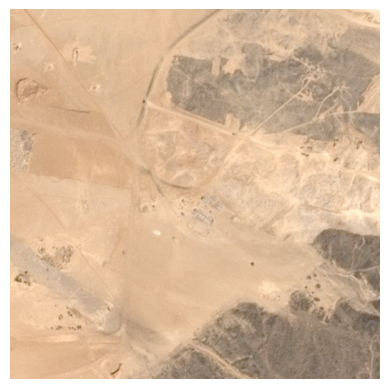

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def classify_image(image_path):
    # Загружаем изображение
    image = cv2.imread(image_path)
    if image is None:
        print("Ошибка при загрузке изображения")
        return

    # Преобразуем изображение в цветовое пространство HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Определим диапазоны для цветов, характерных для пустыни и леса
    # Для пустыни: желтые, оранжевые оттенки
    lower_desert = np.array([15, 100, 100])
    upper_desert = np.array([45, 255, 255])
    
    # Для леса: зеленые оттенки
    lower_forest = np.array([35, 50, 50])
    upper_forest = np.array([85, 255, 255])

    # Создаем маски для пустыни и леса
    desert_mask = cv2.inRange(hsv_image, lower_desert, upper_desert)
    forest_mask = cv2.inRange(hsv_image, lower_forest, upper_forest)

    # Находим количество пикселей в маске для каждого типа
    desert_pixels = np.sum(desert_mask) / 255  # Количество белых пикселей в маске пустыни
    forest_pixels = np.sum(forest_mask) / 255  # Количество белых пикселей в маске леса

    # Сравниваем, какое количество пикселей больше
    if desert_pixels > forest_pixels:
        return "Пустыня"
    elif forest_pixels > desert_pixels:
        return "Лес"
    else:
        return "Неопределено"  # Если количество пикселей приблизительно одинаково
    
img_path = 'desert_forest/test_image_06.jpg'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(classify_image(img_path))
plt.imshow(image)
plt.axis('off')  
plt.show()

# Задача №2 - Реализовать Image-blending на основе сшивки по градиентам

Задача - взять фото двух лиц : ваше и друга, с помощью метода Poisson image editing совместить глаза, нос и рот с первого изображения со вторым. Суть в том, что при использовании такого метода границы совмещенного изображения не видны.

Статья, где описан метод  

Patrick Pérez, Michel Gangnet, and Andrew Blake. 2003. Poisson image editing. ACM Trans. Graph. 22, 3 (July 2003), 313–318. https://doi.org/10.1145/882262.882269

Пример такого совмещения:

<img src="../homework/blending/blending.png" alt="Drawing" style="width: 700px;"/>


In [ ]:
# Ваш код

# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

Пример исходного изображения и нарезанных ячеек клетки.
<img src="../img/cell_example.png" alt="Drawing" style="width: 500px;"/>

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

In [ ]:
# Ваш код